In [1]:
import numpy as np
import h5py 
from matplotlib import pyplot as plt
from MD_AE_model import *

In [2]:
folder = "C:/Users/tracy/OneDrive - Imperial College London/PhD/Code_md-ae/MD_2__2022_02_02__16_51_24/"

filename = folder + 'results.h5'
file = h5py.File(filename,'r')
u_train = np.array(file.get('u_train')) # fluctuating velocity if REMOVE_MEAN is true
y_train = np.array(file.get('y_train'))
u_test = np.array(file.get('u_test')) # fluctuating velocity if REMOVE_MEAN is true
y_test = np.array(file.get('y_test'))
u_avg = np.array(file.get('u_avg'))
latent_train = np.array(file.get('latent_train'))
latent_test = np.array(file.get('latent_test'))
modes_train = np.array(file.get('modes_train'))
modes_test = np.array(file.get('modes_test')) #(modes,snapshots,Nx,Ny,Nu)
file.close()

filename = folder + 'Model_param.h5'
file = h5py.File(filename,'r')
lmb = file.get('lmb')[()]#1e-05 #regulariser
drop_rate = file.get('drop_rate')[()]
features_layers = np.array(file.get('features_layers')).tolist()
latent_dim = file.get('latent_dim')[()]
act_fct = file.get('act_fct')[()].decode()
resize_meth = file.get('resize_meth')[()].decode()
filter_window= np.array(file.get('filter_window')).tolist()
batch_norm = file.get('batch_norm')[()]
file.close()

0.7067236301562139


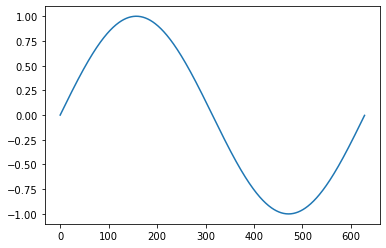

In [45]:
plt.plot(np.sin(np.r_[0:2*np.pi:0.01]))
print(np.mean(np.sin(np.r_[0:2*np.pi:0.01])**2,0)**0.5)

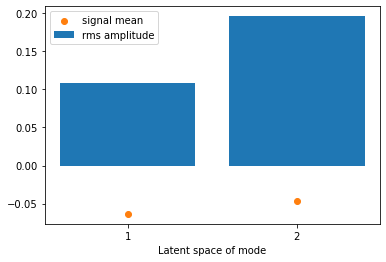

In [46]:
#========================= RMS amplitude of latent variable =====================
# amp_rms = np.mean(latent_test**2,0)**0.5
amp_rms = np.mean((latent_test-np.mean(latent_test,0))**2,0)**0.5 
plt.figure()
plt.bar(np.arange(latent_dim)+1,amp_rms,label='rms amplitude')
plt.scatter(np.arange(latent_dim)+1,np.mean(latent_test,0),label='signal mean')
plt.xticks(np.arange(latent_dim)+1)
plt.legend()
plt.xlabel("Latent space of mode")
plt.show()

In [ ]:
#============================ energy spectrum of signal ==========================